# Lets Start the Coding 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Starting with Importing the Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

sns.set()

## DATA

In [3]:
mnist_dataset,mnist_info = tfds.load(name='mnist',as_supervised=True,with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
mnist_info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [5]:
#splitting the data into training and testing
mnist_train,mnist_test = mnist_dataset['train'],mnist_dataset['test']

#then splitting the train into train and valid samples
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
#casting the values to integer
num_validation_samples = tf.cast(num_validation_samples,tf.int64)

num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples,tf.int64)

#definig a function for Scaling the image
def scale(image,label):
  image = tf.cast(image,tf.float32)
  image /= 255.
  return image ,label

scaled_train_and_vaidation_data = mnist_train.map(scale)

test_data = mnist_test.map(scale)

In [16]:
BUFFER_SIZE = 10000

shuffled_train_and_validation_data = scaled_train_and_vaidation_data.shuffle(BUFFER_SIZE)
validation_data = shuffled_train_and_validation_data.take(num_validation_samples)
train_data = shuffled_train_and_validation_data.skip(num_validation_samples)

BATCH_SIZE = 100
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples)
test_data = test_data.batch(num_test_samples)

validation_inputs,validation_targets = next(iter(validation_data))
test_inputs ,test_targets = next(iter(test_data))

In [19]:
test_inputs = tf.reshape(test_inputs,[10000,28,28,1])
test_targets = tf.reshape(test_targets,[10000])

In [20]:
[validation_inputs.shape,validation_targets.shape,test_inputs.shape,test_targets.shape]

[TensorShape([6000, 28, 28, 1]),
 TensorShape([6000]),
 TensorShape([10000, 28, 28, 1]),
 TensorShape([10000])]

## Model

### Outline the base model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam

In [22]:
input_size = 784
output_size = 10
hidden_layer = 50

model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(28,28,1)))

model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(hidden_layer,activation='relu'))
model.add(Dense(hidden_layer,activation='relu'))

model.add(Dense(output_size,activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

## Training

### Now lets start trainig the data

In [23]:
NUM_EPOCHS = 5

model.fit(train_data,epochs=NUM_EPOCHS,validation_data=(validation_inputs,validation_targets),verbose=1)

Epoch 1/5
540/540 [==============================] - 99s 182ms/step - loss: 0.1905 - accuracy: 0.9427 - val_loss: 0.0748 - val_accuracy: 0.9793
Epoch 2/5
540/540 [==============================] - 101s 187ms/step - loss: 0.0630 - accuracy: 0.9804 - val_loss: 0.0516 - val_accuracy: 0.9858
Epoch 3/5
540/540 [==============================] - 99s 182ms/step - loss: 0.0416 - accuracy: 0.9872 - val_loss: 0.0425 - val_accuracy: 0.9892
Epoch 4/5
540/540 [==============================] - 99s 182ms/step - loss: 0.0327 - accuracy: 0.9896 - val_loss: 0.0338 - val_accuracy: 0.9907
Epoch 5/5
540/540 [==============================] - 98s 181ms/step - loss: 0.0261 - accuracy: 0.9913 - val_loss: 0.0303 - val_accuracy: 0.9930


## Model Evaluation


### Evaluation function of cnn model

In [24]:
score = model.evaluate(test_inputs,test_targets,verbose=1)
print('Test Accuracy : {:.4f}'.format(score[1]))

313/313 [==============================] - 5s 15ms/step - loss: 0.0391 - accuracy: 0.9864
Test Accuracy : 0.9864


In [25]:
predicted_classes = model.predict_classes(test_inputs)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


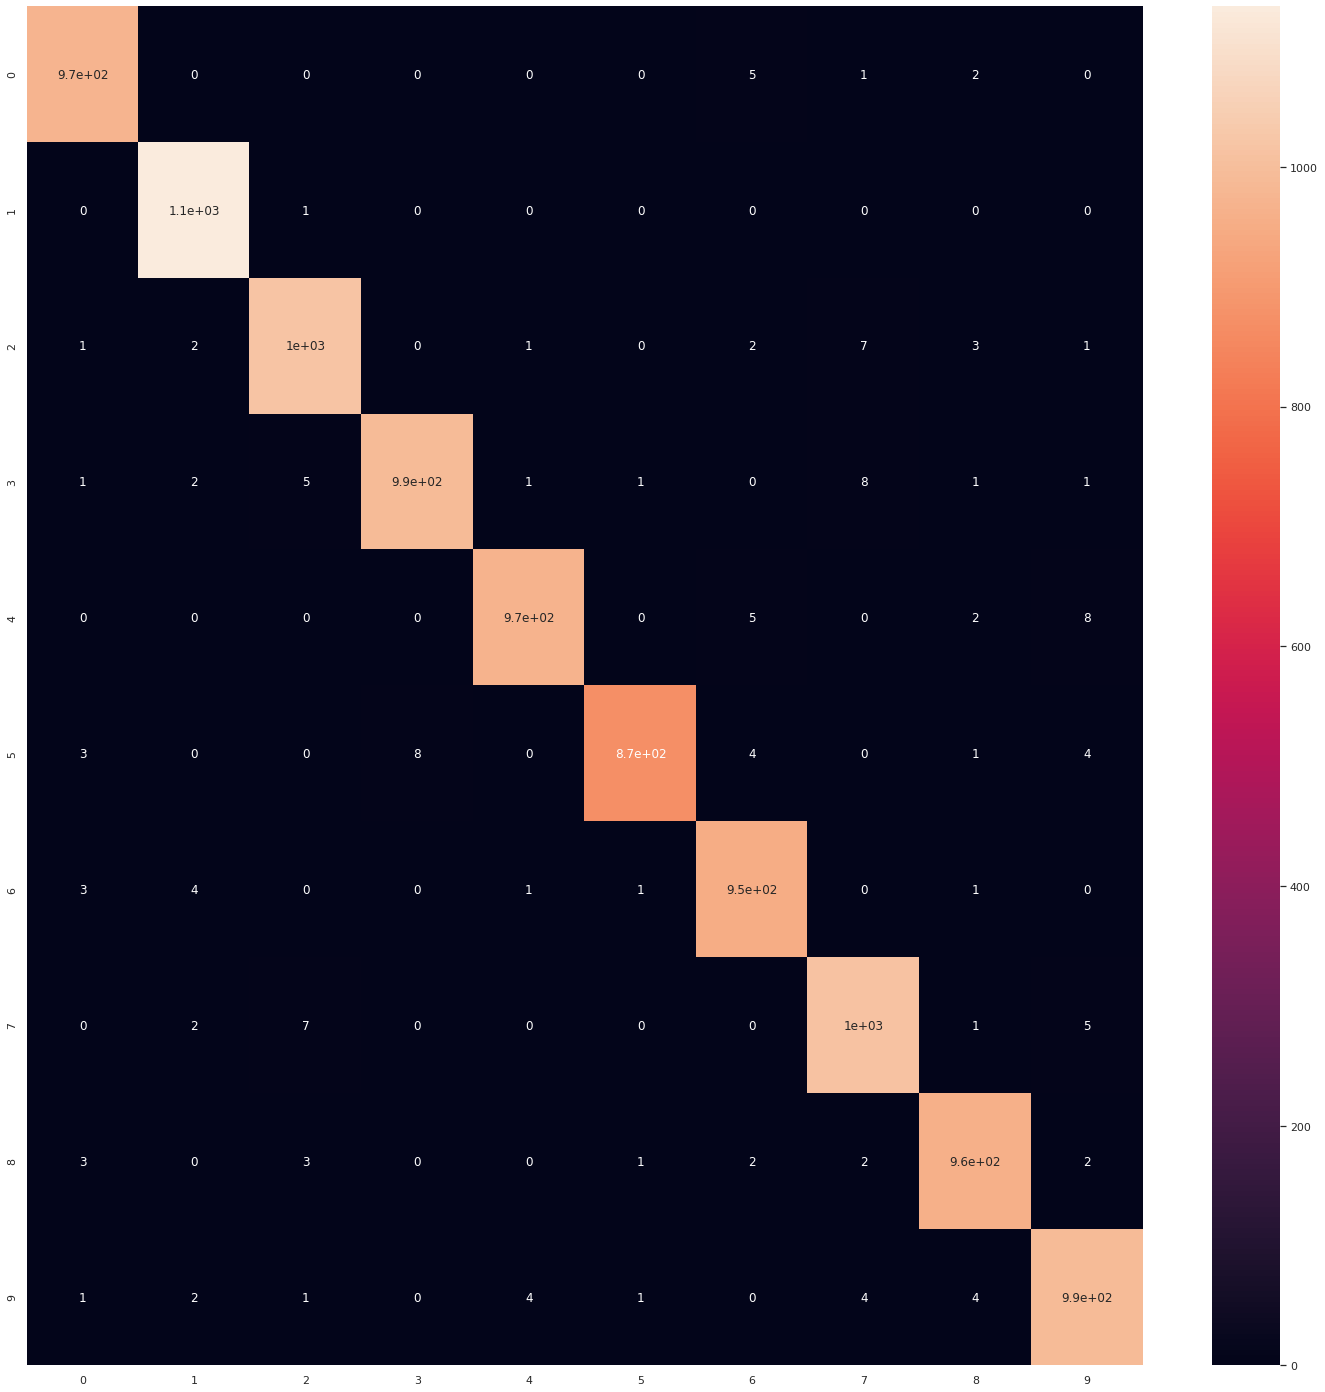

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_targets, predicted_classes)
plt.figure(figsize = (25,25))
sns.heatmap(cm, annot=True)

## Great Job!!! We have got a good accuracy